In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.metrics.cluster import v_measure_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Tratando a Base

In [3]:
# carregando os dados corrigido o separador e atribuindo nomes as colunas
colunas = ['Indivíduos','Atividade','Timestamp','Aceleração no eixo X','Aceleração no eixo Y','Aceleração no eixo Z', '']
dados = pd.read_csv('coleta.txt', sep =',', names = colunas, low_memory=False)
dados.drop([""], axis=1, inplace=True)
dados


,Indivíduos,Atividade,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
41682,20,Downstairs,2.253812e+12,3.910000,6.590000,0.612916
41683,20,Downstairs,2.253862e+12,1.990000,2.960000,-1.729784
41684,20,Downstairs,2.253912e+12,6.780000,7.970000,-0.081722
41685,20,Downstairs,2.253962e+12,6.700000,6.130000,3.023717


In [20]:
# removendo os valores duplicados para garantir a limpesa e valores NA
dados.drop_duplicates();

#adicionando os tipos na descrição da base 
dados.describe(include=['float64', 'int64','object', 'bool'])

#Mudando os valores que estão faltando, para 0
dados = dados.replace("0", np.NaN)

#Mudando o tipo dos valores
for col in dados.columns:
    if dados[col].dtypes == 'object':
        dados[col] = dados[col].fillna(dados[col].value_counts().index[0])
        
# checando onde tem valores nulos
# dados[dados['Aceleração no eixo Z'].isnull()].shape[0]
# tratando:
dados = dados.fillna({'Aceleração no eixo Z':0})
dados[dados['Aceleração no eixo Z'].isnull()].shape[0]
dados = dados[~np.isnan(dados).any(axis=1)]

atividades = dados['Atividade'].unique()
atividades

array([1., 3., 2., 0.])

In [21]:
#subistituir com Label encoder, subistituindo dados categoricos em númericos
atributos = ["Indivíduos","Atividade","Timestamp","Aceleração no eixo X",
           "Aceleração no eixo Y", "Aceleração no eixo Z" ]
enc = OrdinalEncoder()
enc.fit(dados[atributos])
dados[atributos] = enc.transform(dados[atributos])
dados.describe(include=['float64', 'int64','object', 'bool'])
dados

,Indivíduos,Atividade,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
0,2.0,1.0,0.0,710.0,1148.0,336.0
1,2.0,1.0,0.0,1008.0,1074.0,348.0
2,2.0,1.0,0.0,1002.0,1054.0,321.0
3,2.0,1.0,0.0,714.0,1451.0,402.0
4,2.0,1.0,0.0,684.0,1117.0,511.0
...,...,...,...,...,...,...
41681,1.0,0.0,0.0,977.0,824.0,356.0
41682,1.0,0.0,0.0,950.0,829.0,339.0
41683,1.0,0.0,0.0,850.0,640.0,278.0
41684,1.0,0.0,0.0,1099.0,902.0,321.0


In [22]:
# Caso precise o tempo em segundos, minutos ou em horas (DEPENDE DA EMPRESA)
# deixarei em minutos

tempo = dados['Timestamp']
dados_novo = pd.to_timedelta(tempo).dt.total_seconds()

#mudar para horas
# dados_novo / 3600

#mudar para minutos
dados['Timestamp'] = dados_novo / 60
tempo

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41681    0.0
41682    0.0
41683    0.0
41684    0.0
41685    0.0
Name: Timestamp, Length: 41686, dtype: float64

In [24]:
dados

,Indivíduos,Atividade,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
0,2.0,1.0,0.0,710.0,1148.0,336.0
1,2.0,1.0,0.0,1008.0,1074.0,348.0
2,2.0,1.0,0.0,1002.0,1054.0,321.0
3,2.0,1.0,0.0,714.0,1451.0,402.0
4,2.0,1.0,0.0,684.0,1117.0,511.0
...,...,...,...,...,...,...
41681,1.0,0.0,0.0,977.0,824.0,356.0
41682,1.0,0.0,0.0,950.0,829.0,339.0
41683,1.0,0.0,0.0,850.0,640.0,278.0
41684,1.0,0.0,0.0,1099.0,902.0,321.0


In [25]:
#calculando métricas estatisticas da base 
dados.describe().round(2)

,Indivíduos,Atividade,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
count,41686.00,41686.00,41686.0,41686.00,41686.00,41686.00
mean,1.06,1.85,0.0,865.52,925.70,334.62
std,0.58,1.03,0.0,354.77,339.41,107.60
min,0.00,0.00,0.0,0.00,0.00,0.00
25%,1.00,1.00,0.0,661.25,663.00,269.00
50%,1.00,1.00,0.0,803.00,939.00,323.00
75%,1.00,3.00,0.0,1043.00,1188.00,388.00
max,2.00,3.00,0.0,1684.00,1508.00,765.00


# Visualização de métricas com gráficos 

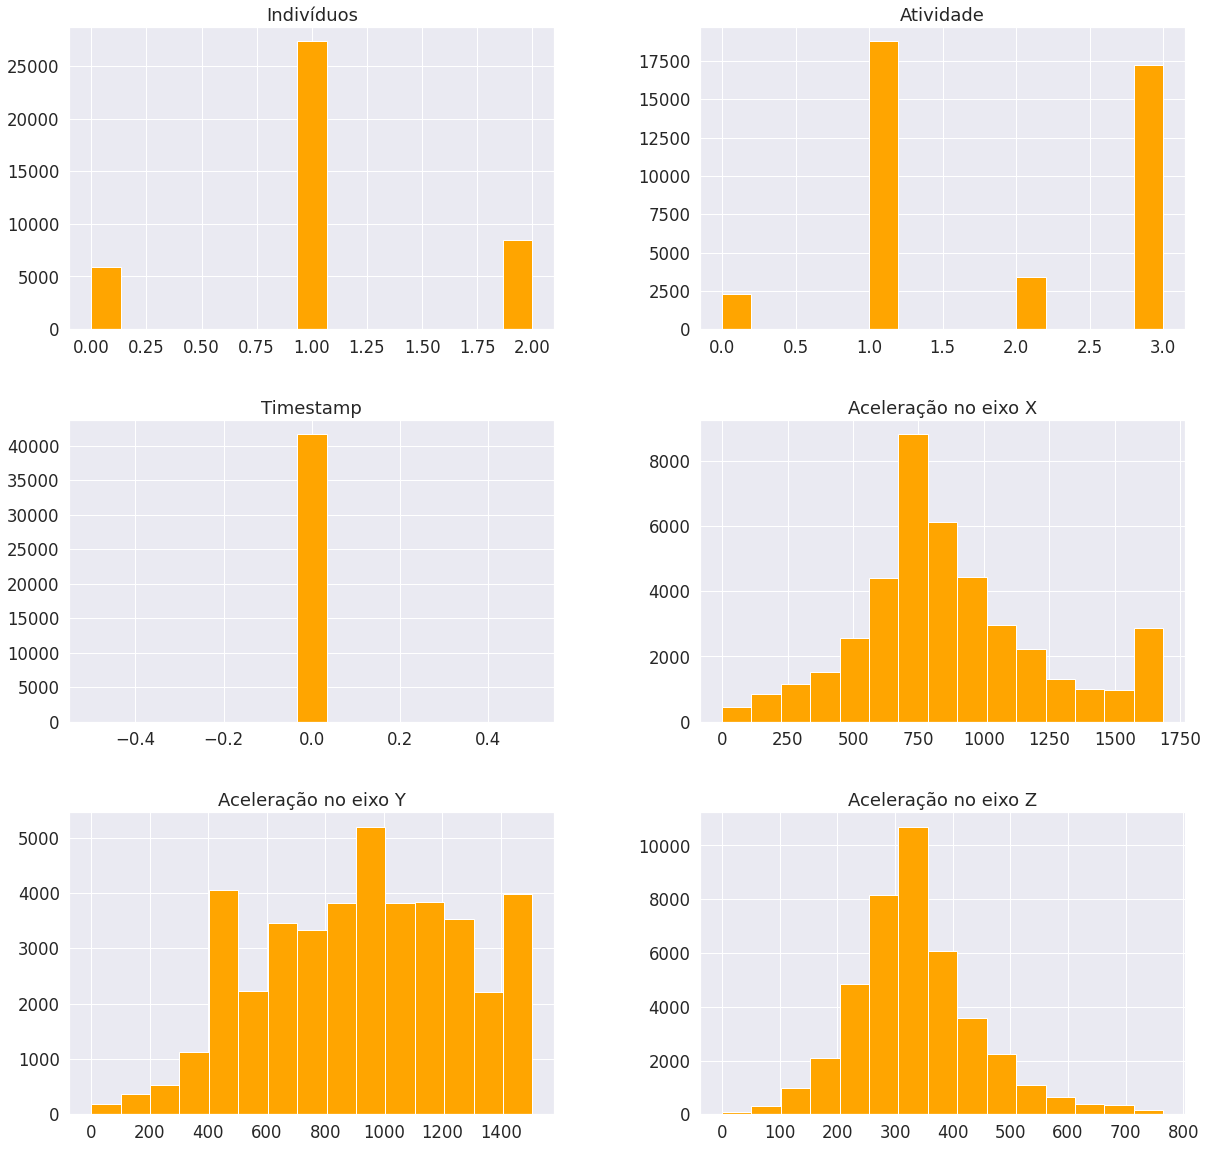

In [26]:
# mostrando as amostras com graficos 
sns.set(font_scale=1.5, rc={'figure.figsize':(20,20)})
colunas_eixo = dados.hist(bins=15, color='orange')

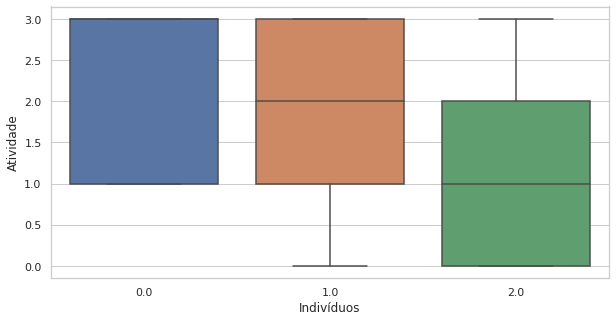

In [73]:
# Ver a relação entre a média de Indivíduos e atividades feitas
plt.figure( figsize=(10,5))
sns.boxplot(data= dados, x= 'Indivíduos', y='Atividade');

#Todos os modelos irão tentar prever a próxima atividade que cada indivíduo poderá realizar.

## RamdomForest 

In [28]:
#Criar meu Y class e X bases X (caracteristicas e y previsor)
y = dados.iloc[:,1]
X = dados.iloc[:,2:6]
X

,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
0,0.0,710.0,1148.0,336.0
1,0.0,1008.0,1074.0,348.0
2,0.0,1002.0,1054.0,321.0
3,0.0,714.0,1451.0,402.0
4,0.0,684.0,1117.0,511.0
...,...,...,...,...
41681,0.0,977.0,824.0,356.0
41682,0.0,950.0,829.0,339.0
41683,0.0,850.0,640.0,278.0
41684,0.0,1099.0,902.0,321.0


In [29]:
#Padronizando
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3
0,0.0,-0.438375,0.654965,0.012844
1,0.0,0.401611,0.436938,0.124367
2,0.0,0.384698,0.378012,-0.126559
3,0.0,-0.427100,1.547697,0.626217
4,0.0,-0.511663,0.563630,1.639213
...,...,...,...,...
41681,0.0,0.314229,-0.299639,0.198715
41682,0.0,0.238123,-0.284907,0.040725
41683,0.0,-0.043751,-0.841760,-0.526181
41684,0.0,0.658116,-0.069827,-0.126559


In [30]:
# Treinando 75% para treinamento e 25% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
# 100 arvore de decisão
floresta_aleatoria = RandomForestClassifier(n_estimators=100)
floresta_aleatoria.fit(X_treino, y_treino)

RandomForestClassifier()

[[ 180   73  121  208]
 [  42 4122   86  554]
 [  94   83  371  313]
 [  53  307  170 3645]]


<Axes: >

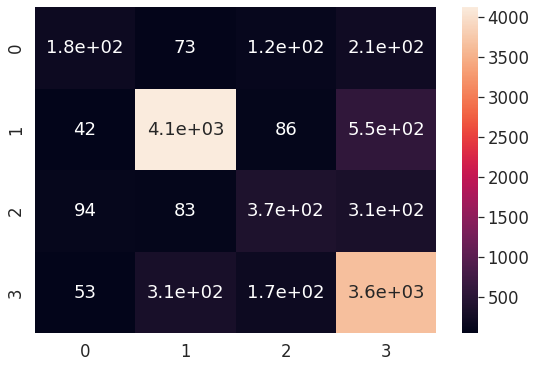

In [34]:
previsao = floresta_aleatoria.predict(X_teste)


# clasificando com matriz de confuzão para ter noção dos erros previstos
matriz_confusao = confusion_matrix(y_teste, previsao)
print(matriz_confusao)

plt.figure( figsize = (9,6))
sns.heatmap(matriz_confusao, annot= True)

In [35]:
AcuraciaRamdomForest = floresta_aleatoria.score(X_teste, y_teste)
AcuraciaRamdomForest

0.7981193628862022

In [36]:
# raiz quadrada da RamdomForest
RaizRamdomForest = np.sqrt(mean_squared_error(y_teste, previsao))
RaizRamdomForest

0.8437745426326022

In [37]:
# calcular todas as metricas
report = classification_report(y_teste, previsao)
print(report)

# recall = o que meu modelo classificou como certo ou errado em %
# precision e o nivel de precisão do modelo

              precision    recall  f1-score   support

         0.0       0.49      0.31      0.38       582
         1.0       0.90      0.86      0.88      4804
         2.0       0.50      0.43      0.46       861
         3.0       0.77      0.87      0.82      4175

    accuracy                           0.80     10422
   macro avg       0.66      0.62      0.63     10422
weighted avg       0.79      0.80      0.79     10422



In [38]:
dados_novos = dados
prever = dados_novos.iloc[:, 1:5].values



dados_novos['valor previsto'] = floresta_aleatoria.predict(prever)

In [39]:
dados_novos['valor previsto'].value_counts()

3.0    41682
1.0        3
2.0        1
Name: valor previsto, dtype: int64

In [40]:
dados_novos['valor previsto'] = dados_novos['valor previsto'].replace({0.0:'Jogging', 1.0:'Walking', 
    2.0 :'Upstairs',3.0:'Downstairs',4.0:'Sitting' ,5.0:'Standing'})
dados_novos

,Indivíduos,Atividade,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z,valor previsto
0,2.0,1.0,0.0,710.0,1148.0,336.0,Downstairs
1,2.0,1.0,0.0,1008.0,1074.0,348.0,Downstairs
2,2.0,1.0,0.0,1002.0,1054.0,321.0,Downstairs
3,2.0,1.0,0.0,714.0,1451.0,402.0,Downstairs
4,2.0,1.0,0.0,684.0,1117.0,511.0,Downstairs
...,...,...,...,...,...,...,...
41681,1.0,0.0,0.0,977.0,824.0,356.0,Downstairs
41682,1.0,0.0,0.0,950.0,829.0,339.0,Downstairs
41683,1.0,0.0,0.0,850.0,640.0,278.0,Downstairs
41684,1.0,0.0,0.0,1099.0,902.0,321.0,Downstairs


# XGBoost

In [41]:
#Criar meu Y class e X bases X (caracteristicas e y previsor)
y2 = dados.iloc[:,1]
X2 = dados.iloc[:,2:6]
X2


,Timestamp,Aceleração no eixo X,Aceleração no eixo Y,Aceleração no eixo Z
0,0.0,710.0,1148.0,336.0
1,0.0,1008.0,1074.0,348.0
2,0.0,1002.0,1054.0,321.0
3,0.0,714.0,1451.0,402.0
4,0.0,684.0,1117.0,511.0
...,...,...,...,...
41681,0.0,977.0,824.0,356.0
41682,0.0,950.0,829.0,339.0
41683,0.0,850.0,640.0,278.0
41684,0.0,1099.0,902.0,321.0


In [42]:
#Padronizando
X2 = StandardScaler().fit_transform(X)
X2 = pd.DataFrame(X)
X2

,0,1,2,3
0,0.0,-0.438375,0.654965,0.012844
1,0.0,0.401611,0.436938,0.124367
2,0.0,0.384698,0.378012,-0.126559
3,0.0,-0.427100,1.547697,0.626217
4,0.0,-0.511663,0.563630,1.639213
...,...,...,...,...
41681,0.0,0.314229,-0.299639,0.198715
41682,0.0,0.238123,-0.284907,0.040725
41683,0.0,-0.043751,-0.841760,-0.526181
41684,0.0,0.658116,-0.069827,-0.126559


In [43]:
Xtr, Xval, ytr, yval = train_test_split(X2, y2, test_size=0.25, random_state=42)
arvores_XGBoost = XGBRegressor(learning_rate=0.08, 
                                 n_estimators=100,
                                 max_depth=6,
                                 min_child_weight=1,
                                 subsample=0.75,
                                 colsample_bynode=0.5,
                                 random_state=0,)

arvores_XGBoost.fit(Xtr, ytr)

xgboostprevisao = arvores_XGBoost.predict(Xval)

np.sqrt(mean_squared_error(yval, xgboostprevisao))

0.7475940998963959

In [44]:
AcuraciaXGBoost = arvores_XGBoost.score(Xtr, ytr)
AcuraciaXGBoost


0.5259688204978742

# KNN

In [45]:
#primeiramenta vamos dividir a base usando o Holdout em 75% treinamento e 30% teste 
#usaremos o valor de k de 1 até 15 ou seja o k vai ter um valor diferente de vizinho por vez que repetir
#por fim o k-fold pega apenas os dados de treino para fazer a validação no caso o x_treino
#retornado pelo holdout ous seja os 75% dividido em 10 parcelas
#treinando o knn com o conjunto atual feito
#por fim temos o valor medio de Acurácia para cada valor do knn
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)
valores_k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
resultados_knn = []
for k in valores_k:
    resultados_k = []
    knn = KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True)
    for index_train, index_valid in kf.split(X_treino):
        X_train, X_validacao = X_treino.iloc[index_train], X_treino.iloc[index_valid]
        y_train, y_validacao = y_treino.iloc[index_train], y_treino.iloc[index_valid]
        knn.fit(X_train, y_train)
        resultados_k.append(knn.score(X_validacao, y_validacao))
    resultados_knn.append(sum(resultados_k)/len(resultados_k))
resultados_knn

[0.7451705483027011,
 0.7136649588409292,
 0.7567489193352596,
 0.7600437524207154,
 0.7680078428628454,
 0.7690636380432453,
 0.7745331612208365,
 0.77626046521525,
 0.7782432781087921,
 0.7826579370520844,
 0.7811214770083936,
 0.7829778960659036,
 0.7839053843671847,
 0.7840967500569309,
 0.7844168522932271]

In [46]:
#usando o melhor valor obtido do parametro irei usar ele para fazer o treinamento real 
#valor da acuracia usando o indice 15

knn = KNeighborsClassifier(n_neighbors= 15)
knn.fit(X_treino, y_treino)
AcuraciaKnn = knn.score(X_teste, y_teste)
AcuraciaKnn

0.7818077144502015

# SVM

In [47]:
# para o Svc usaremos 4 valores de kernel
# para saber qual e o melhor apartir da sua media

valores_kernel = ["linear", "poly", "rbf", "sigmoid"]
resultados_svm = []

for kernel in valores_kernel:
    resultados_kernel = []
    svc = SVC(kernel=kernel)
    kf = KFold(n_splits=10, shuffle=True)
    for index_train, index_valid in kf.split(X_treino):
        X_train, X_validacao = X_treino.iloc[index_train], X_treino.iloc[index_valid]
        y_train, y_validacao = y_treino.iloc[index_train], y_treino.iloc[index_valid]
        svc.fit(X_train, y_train)
        resultados_kernel.append(svc.score(X_validacao, y_validacao))
    resultados_svm.append(sum(resultados_kernel)/len(resultados_kernel))
resultados_svm


[0.5710087015838974,
 0.5648027488894631,
 0.7450421493519899,
 0.4094165300426537]

In [49]:
#de acordo valor de kernel obtido vamos usar o rbf para construir o classificador
svc = SVC(kernel="rbf")
svc.fit(X_treino, y_treino)
AcuraciaSVM = svc.score(X_teste, y_teste)
AcuraciaSVM

0.7381500671656112

# Rede Neural MLP

In [51]:
#para a mlp rede neural testaremos 4 codigos de ativação para saber qual e o melhor apartir da sua media

valores_ativacao = ["identity", "logistic", "tanh", "relu"]
resultados_mlp = []

for ativacao in valores_ativacao:
    resultados_ativacao = []
    mlp = MLPClassifier(activation=ativacao)
    kf = KFold(n_splits=10, shuffle=True)
    for index_train, index_valid in kf.split(X_treino):
        X_train, X_validacao = X_treino.iloc[index_train], X_treino.iloc[index_valid]
        y_train, y_validacao = y_treino.iloc[index_train], y_treino.iloc[index_valid]
        mlp.fit(X_train, y_train)
        resultados_ativacao.append(svc.score(X_validacao, y_validacao))
    resultados_mlp.append(sum(resultados_ativacao)/len(resultados_ativacao))
resultados_mlp

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.7462577194357607,
 0.7462580365712457,
 0.7462576478245222,
 0.7462574227606297]

In [52]:
mlp = MLPClassifier(activation="logistic")
mlp.fit(X_treino, y_treino)
AcuraciaMLP = mlp.score(X_teste, y_teste)
AcuraciaMLP

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.747457301861447

# Naive Bayes

In [54]:
gnb = GaussianNB()
gnb.fit(X_treino, y_treino)
AcuraciaNav = gnb.score(X_teste, y_teste)
AcuraciaNav

0.6917098445595855

# Árvore de decisão (Simples)


In [57]:
arvore = DecisionTreeClassifier(criterion="entropy")
arvore.fit(X_treino, y_treino)

AcuraciaArvoreS = arvore.score(X_teste, y_teste)
AcuraciaArvoreS

0.7442909230473997

# Comparando Acurácia dos Algoritmos de classificação

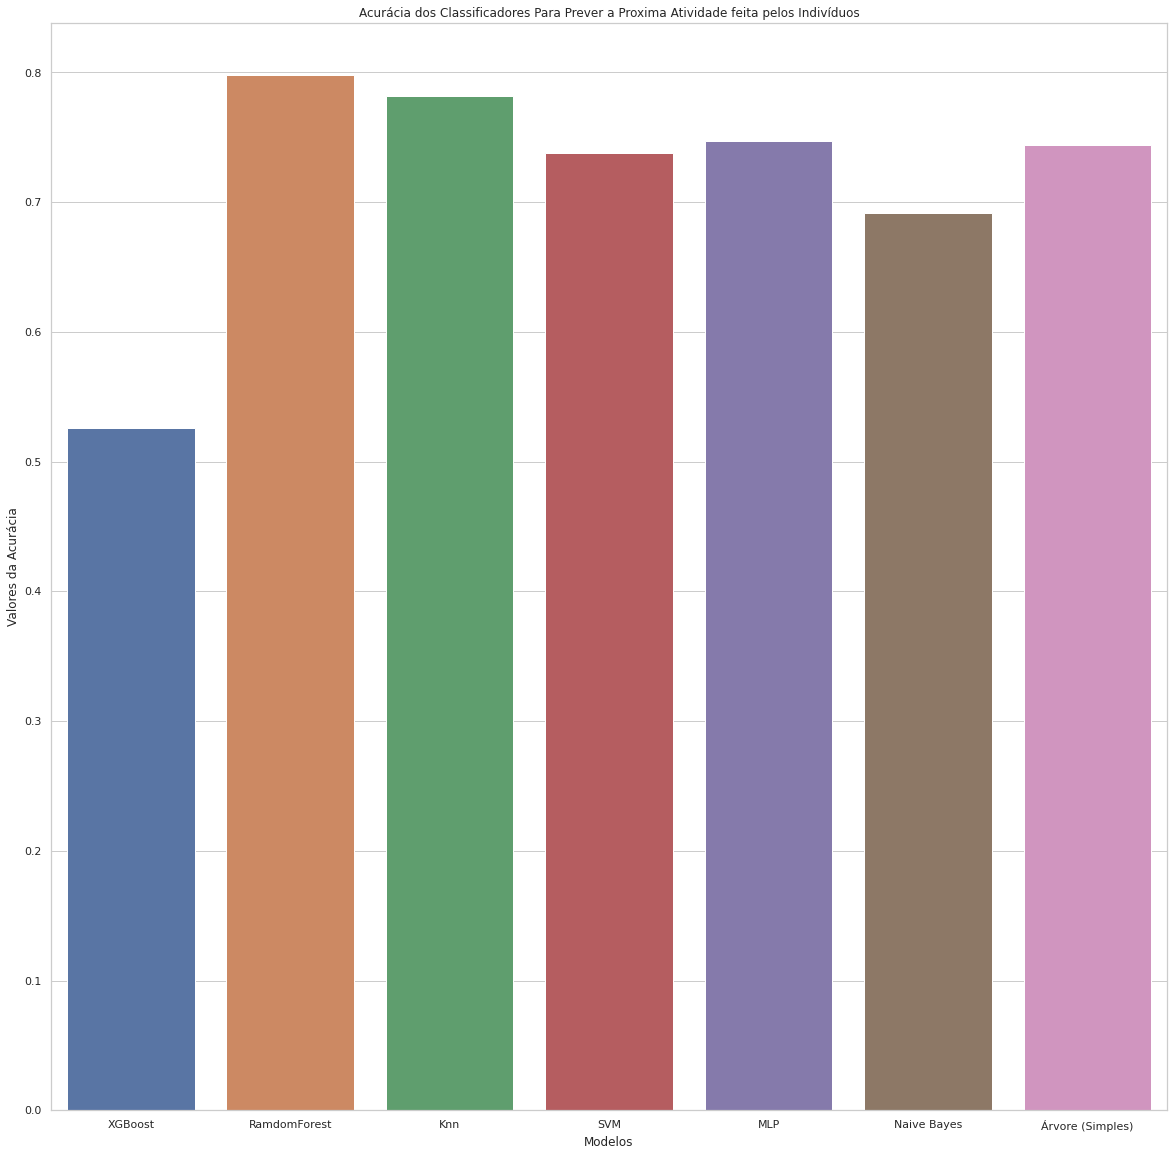

In [75]:
# mostrando as amostras com graficos 
AcuraciaGeral = {'Categorias' : ['XGBoost','RamdomForest','Knn','SVM','MLP', 'Naive Bayes', 'Árvore (Simples)'],
                 'Valores' : [AcuraciaXGBoost, AcuraciaRamdomForest,AcuraciaKnn, AcuraciaSVM,AcuraciaMLP, AcuraciaNav, AcuraciaArvoreS]
                 }

df = pd.DataFrame(AcuraciaGeral)

sns.set(font_scale=1.5, rc={'figure.figsize':(20,20)})
sns.set(style='whitegrid')
# colunas_eixo = df.hist(bins=15, color='orange')
grafico = sns.barplot(x='Categorias', y='Valores', data=df)
grafico.set_title('Acurácia dos Classificadores Para Prever a Proxima Atividade feita pelos Indivíduos')
grafico.set_xlabel('Modelos')
grafico.set_ylabel('Valores da Acurácia')
plt.show()